In [19]:
%load_ext autoreload
%autoreload 2
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt

from src.models.training.train import TrainModule
from src.loop_calling.dataset.loop_dataset import LoopDataset
from src.utils import predict_matrix, plot_and_save_matrices, load_bigwig_signal
from src.ledidi.ledidi_extruding_to_stable import evaluate_element
from src.ledidi.utils import report_nt_changes, plot_multi_site_attributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
CKPT="/cluster/work/boeva/shoenig/ews-ml/training_runs_A673_WT/checkpoints/NEW_HOPE/models/epoch=7-step=8856.ckpt"

In [11]:
%%capture
model = TrainModule.load_from_checkpoint(CKPT)
model.eval()
model.to("cuda")

In [4]:
dataset = LoopDataset(
        regions_file_path="/cluster/work/boeva/shoenig/ews-ml/data/loop_calling/processed/A673_WT/500kb_loops.csv",
        cool_file_path="/cluster/work/boeva/shoenig/ews-ml/data/corigami/raw/A673_WT/contact_matrix_data/A673_WT_CTCF_5000.cool",
        fasta_dir="/cluster/work/boeva/minjwang/data/hg19/chromosomes",
        genomic_feature_path=None,
        mode="test",
        val_chroms=[],
        test_chroms=["chr2", "chr6", "chr19"],
        use_pretrained_backbone=True
    )

In [16]:
elem = dataset[872]
pred = predict_matrix(elem, model, 'cuda')

In [17]:
elem["idx"] = 872

In [20]:
evaluate_element(elem, model, device="cuda", run_dir="ex3")

Starting run
[METRICS] BASELINE: ratio=0.562 corner=1.032 mean_x=1.834 mean_y=1.144
i: 15, j: 91, L:524288 old: 524288
Start: 80000
End: 450000
iter=I	input_loss=0.0	output_loss=25.01	total_loss=25.01	time=0.0
iter=100	input_loss=1.676e+03	output_loss=0.902	total_loss=135.0	time=40.79
iter=200	input_loss=922.0	output_loss=0.07191	total_loss=73.83	time=40.82
iter=300	input_loss=744.0	output_loss=0.01243	total_loss=59.53	time=40.89
iter=400	input_loss=457.0	output_loss=0.03335	total_loss=36.59	time=40.9
iter=500	input_loss=320.0	output_loss=0.06464	total_loss=25.66	time=40.89
iter=600	input_loss=288.0	output_loss=0.03972	total_loss=23.08	time=41.02
iter=700	input_loss=287.0	output_loss=0.1498	total_loss=23.11	time=41.08
iter=800	input_loss=234.0	output_loss=0.05176	total_loss=18.77	time=41.11
iter=900	input_loss=246.0	output_loss=0.02747	total_loss=19.71	time=41.08
iter=1000	input_loss=269.0	output_loss=0.02726	total_loss=21.55	time=41.06
iter=1100	input_loss=220.0	output_loss=0.7228	tot

{'idx': 872,
 'loop_start': 219890000,
 'loop_end': 220270000,
 'original_corner_ratio': 1.0315477848052979,
 'edited_corner_ratio': 1.1804383993148804,
 'original_meanX': 1.8340951204299927,
 'edited_meanX': 1.9057495594024658,
 'original_meanY': 1.1435494422912598,
 'edited_meanY': 1.1719770431518555,
 'mutations_raw': [169350],
 'mutations_final': [169350],
 'base_changes': ['C>G'],
 'single_edit_contrib': None,
 'chr': 'chr2',
 'contributions': [],
 'comment': 'Normal'}

In [22]:
edited_sequence = torch.load("./ex3/chr2/best_onehot_872.pt")

In [23]:
deep_copy = copy.deepcopy(elem)
deep_copy['sequence'] = edited_sequence
pred_all = predict_matrix(deep_copy, model, 'cuda')

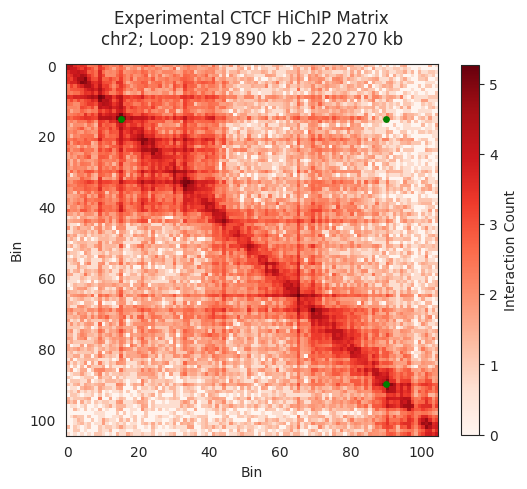

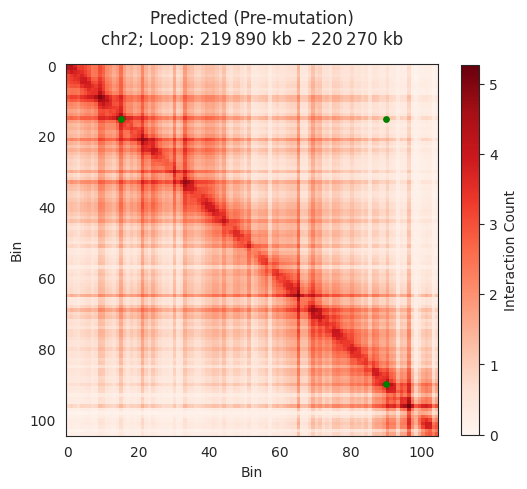

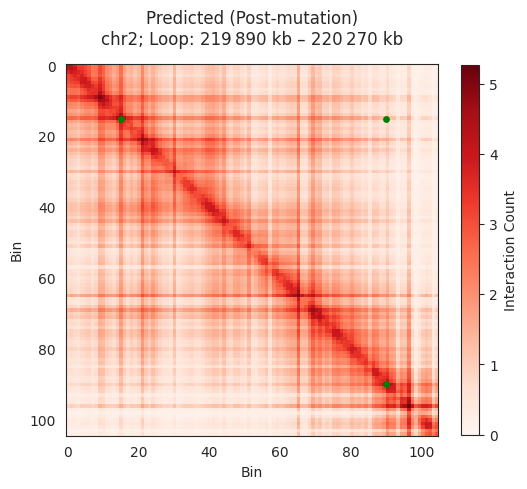

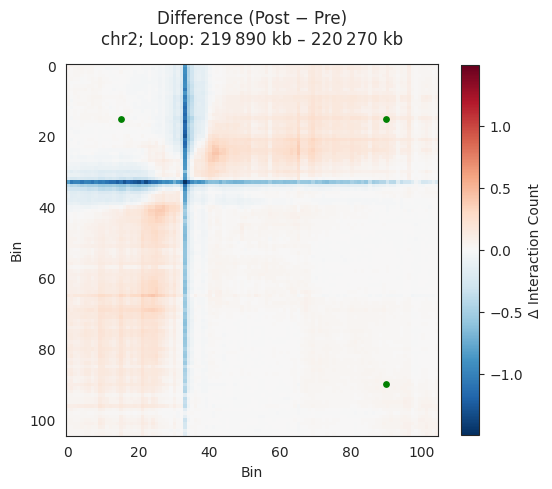

{'exp': '872_new/Extr_To_Stable_exp.svg',
 'pre': '872_new/Extr_To_Stable_pred_pre.svg',
 'post': '872_new/Extr_To_Stable_pred_post.svg',
 'diff': '872_new/Extr_To_Stable_diff.svg'}

In [24]:
%matplotlib inline
plot_and_save_matrices(elem, pred, pred_all, save_dir="872_new", prefix="Extr_To_Stable", show=True)

In [25]:
edits = report_nt_changes(elem["sequence"], deep_copy["sequence"])

Total sequence-positions with any mismatch: 1
169350: C → G


In [26]:
def plot_ctcf(elem, start, end, mark_start, mark_end):
    chrom = elem["chr"]
    signal = load_bigwig_signal("/cluster/work/boeva/shoenig/ews-ml/data/corigami/raw/A673_WT/genomic_features_data/CTCF/A673_WT_CTCF_coverage_FE.bw", chrom, start, end)
    x = np.arange(start, end)
    x = np.linspace(start, end, num=len(signal), endpoint=False)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, signal)
    ax.set_ylabel("Signal")
    ax.set_title("CTCF track")
    ax.set_xlim(start, end)
    
    if (mark_start is not None) and (mark_end is not None):
        hs, he = max(mark_start, start), min(mark_end, end)
        if hs < he:
            ax.axvspan(hs, he, alpha=0.2)
            ax.axvline(hs, linestyle="--", linewidth=0.8)
            ax.axvline(he, linestyle="--", linewidth=0.8)
    
    fig.tight_layout()

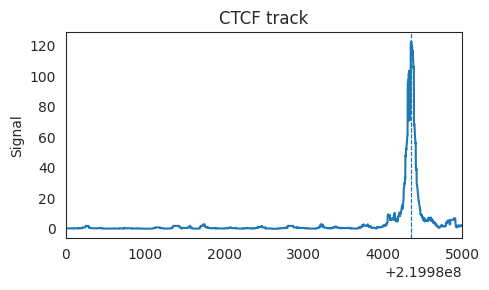

In [27]:
plot_ctcf(elem, elem["region_start"]+165000, elem["region_start"]+170000, elem["region_start"]+169350-1, elem["region_start"]+169350+1)

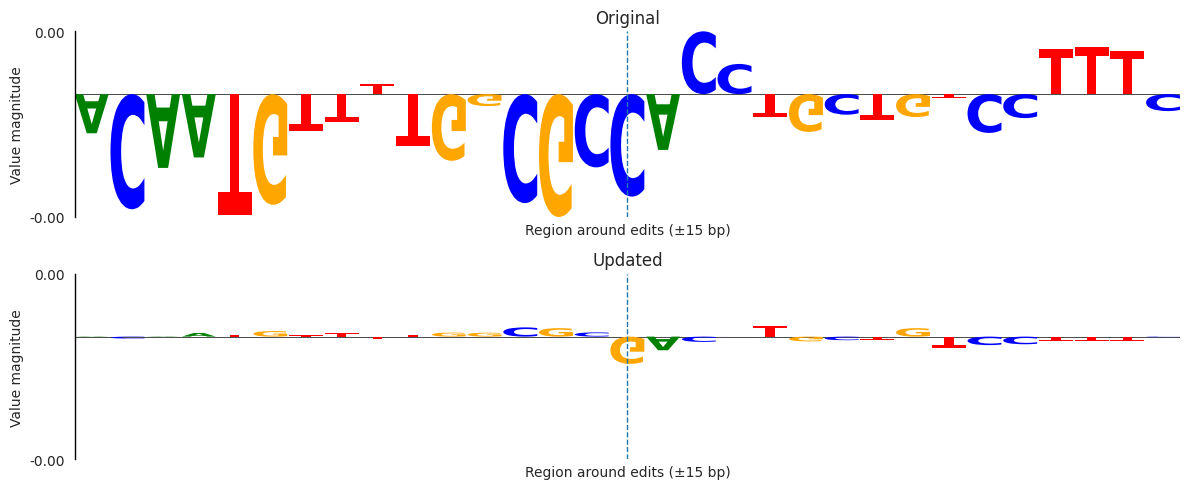

In [33]:
plot_multi_site_attributions(model, elem, edits, window_radius=15)